# Modelo: Gradient Boosting

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import GradientBoostingClassifier

In [2]:
datos = pd.read_csv(
    'https://docs.google.com/spreadsheets/d/1wduqo5WyYmCpaGnE81sLNGU0VSodIekMfpmEwU0fGqs/export?format=csv', low_memory=False
)

resultados = pd.read_csv(
    'https://docs.google.com/spreadsheets/d/1gvZ03uAL6THwd04Y98GtIj6SeAHiKyQY5UisuuyFSUs/export?format=csv', low_memory=False
)

df = pd.merge(datos, resultados, how='left', left_on='id', right_on='id')
df

,barrio,dia,direccion_viento_tarde,direccion_viento_temprano,horas_de_sol,humedad_tarde,humedad_temprano,id,llovieron_hamburguesas_hoy,mm_evaporados_agua,...,presion_atmosferica_temprano,rafaga_viento_max_direccion,rafaga_viento_max_velocidad,temp_max,temp_min,temperatura_tarde,temperatura_temprano,velocidad_viendo_tarde,velocidad_viendo_temprano,llovieron_hamburguesas_al_dia_siguiente
0,Retiro,2016-10-11,Este,Nornoreste,10.7,59.0,56.0,86942,no,16.0,...,1010.2,Estesureste,33.0,29.2,16.8,24.1,25.3,19.0,4.0,no
1,Vélez Sársfield,2016-03-28,Sur,suroeste,0.0,49.0,83.0,102098,no,2.6,...,1021.4,Sur,31.0,16.9,10.6,16.4,12.3,13.0,7.0,no
2,Palermo,2017-05-11,Sursureste,Norte,4.3,59.0,83.0,67154,no,2.4,...,1026.5,Norte,26.0,16.6,4.4,15.7,9.4,9.0,13.0,no
3,Mataderos,2012-05-07,suroeste,Sur,NaN,67.0,93.0,50245,no,NaN,...,1020.0,Oestesuroeste,13.0,11.4,0.8,11.1,4.0,6.0,6.0,no
4,Recoleta,2014-06-19,Nornoreste,Nornoreste,0.8,94.0,97.0,82904,no,0.8,...,1021.9,Nornoreste,33.0,11.6,6.7,11.2,8.8,11.0,15.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116363,Villa Lugano,2011-03-07,Oestesuroeste,Sureste,11.6,35.0,44.0,118424,no,8.4,...,1015.9,suroeste,43.0,28.7,17.4,27.8,23.0,30.0,11.0,no
116364,Saavedra,2009-07-25,Sureste,Sursureste,1.0,68.0,80.0,87436,no,7.4,...,1018.2,Sureste,44.0,26.3,19.0,24.0,21.9,30.0,19.0,si
116365,Villa General Mitre,2013-11-11,suroeste,Sur,11.1,19.0,43.0,116306,no,NaN,...,1014.4,Oestesuroeste,35.0,34.5,10.2,32.8,24.2,24.0,9.0,no
116366,Villa Devoto,2010-08-17,Sursuroeste,NaN,NaN,71.0,99.0,112204,no,NaN,...,1005.2,Sursuroeste,43.0,16.5,5.0,13.6,11.4,26.0,0.0,si


Primero descartamos las filas que contienen NaNs en 'llovieron_hamburguesas_al_dia_siguiente', luego separamos los datos en training y testing.

In [3]:
from sklearn.model_selection import train_test_split

df = df.dropna(subset=['llovieron_hamburguesas_al_dia_siguiente'])
datos_1 = df.iloc[:, :23]
resultados_1 = df.iloc[:,23:]

X_training_val_dev, X_test_holdout, y_training_val_dev, y_test_holdout = train_test_split(
    datos_1, resultados_1, random_state=117, test_size=0.1, stratify=resultados_1
)
X_training, X_val_dev, y_training, y_val_dev = train_test_split(
    X_training_val_dev, y_training_val_dev, random_state=117, test_size=0.3, stratify=y_training_val_dev
)


print("Shape of new dataframes - {} , {}".format(X_training.shape, y_training.shape))
datos_training = X_training.copy()
datos_test_holdout = X_test_holdout.copy()
datos_training

Shape of new dataframes - (71649, 23) , (71649, 1)


,barrio,dia,direccion_viento_tarde,direccion_viento_temprano,horas_de_sol,humedad_tarde,humedad_temprano,id,llovieron_hamburguesas_hoy,mm_evaporados_agua,...,presion_atmosferica_tarde,presion_atmosferica_temprano,rafaga_viento_max_direccion,rafaga_viento_max_velocidad,temp_max,temp_min,temperatura_tarde,temperatura_temprano,velocidad_viendo_tarde,velocidad_viendo_temprano
98355,La Paternal,2014-06-12,Nornoreste,Oestenoroeste,NaN,59.0,69.0,44477,no,NaN,...,1018.7,1021.3,Noroeste,28.0,19.3,12.0,18.8,14.8,15.0,9.0
25931,Villa Soldati,2013-11-11,Oestenoroeste,Oestesuroeste,5.8,62.0,67.0,140981,no,6.4,...,1005.0,1008.5,Este,72.0,33.8,26.0,32.5,30.0,28.0,13.0
19830,Saavedra,2012-11-19,Norte,Sursureste,7.2,71.0,75.0,88619,no,5.2,...,1008.8,1011.2,Estenoreste,35.0,33.1,23.7,28.1,27.1,15.0,6.0
100102,San Cristóbal,2009-02-05,Sureste,Sursureste,NaN,62.0,63.0,90306,no,NaN,...,1007.8,1009.0,Sureste,39.0,30.4,23.3,28.8,28.6,31.0,26.0
77366,Núñez,2016-06-26,Noroeste,Noroeste,NaN,61.0,84.0,63826,no,NaN,...,1016.6,1020.8,Oeste,30.0,12.8,3.3,12.3,6.3,11.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26036,Almagro,2014-01-14,Nornoreste,Norte,NaN,33.0,62.0,4790,no,NaN,...,1018.1,1022.1,Estenoreste,35.0,33.9,14.7,32.2,22.4,13.0,13.0
20182,Agronomía,2012-08-21,Noreste,Sureste,NaN,45.0,84.0,1329,no,NaN,...,1015.3,1020.1,Norte,33.0,16.4,2.1,15.6,7.9,19.0,7.0
2036,Parque Patricios,2012-06-05,Sureste,Sursureste,0.9,66.0,63.0,76201,si,0.6,...,1020.6,1019.7,Sureste,59.0,12.6,10.7,12.0,11.6,31.0,30.0
12108,La Paternal,2014-07-30,Oestenoroeste,Noroeste,NaN,34.0,47.0,44525,NaN,NaN,...,1014.2,1017.1,Oestenoroeste,96.0,22.4,12.7,22.2,19.1,19.0,11.0


Definimos las funciones que vamos a utilizar para preprocesar.

Realizamos un entrenamiento inicial del modelo con algunos parametros seleccionados al azar para ver como funciona.

In [4]:
from preprocessing import preprocessing_gb
from sklearn.impute import SimpleImputer

datos_training_boost, datos_val = preprocessing_gb(X_training.copy(), X_val_dev.copy())

y_training = y_training.reset_index()
y_training = y_training.drop(columns=['index'])
resultados_training_boost = pd.get_dummies(y_training, drop_first=True, columns=['llovieron_hamburguesas_al_dia_siguiente'])

pd.DataFrame(datos_training_boost)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,12.0,7.644989,59.0,69.0,5.45772,0.000000,4.500233,4.437636,1018.700012,1021.3,...,6.0,-1.0,-5.0,8.0,0.0,-2.0,5.0,-1.0,2014.0,6.0
1,11.0,5.800000,62.0,67.0,6.40000,0.000000,3.000000,6.000000,1005.000000,1008.5,...,8.0,0.0,-5.0,8.0,0.0,-1.0,1.0,0.0,2013.0,11.0
2,19.0,7.200000,71.0,75.0,5.20000,1.000000,5.000000,5.000000,1008.799988,1011.2,...,3.0,-1.0,-4.0,6.0,0.0,-4.0,5.0,0.0,2012.0,11.0
3,5.0,7.644989,62.0,63.0,5.45772,0.000000,4.500233,4.437636,1007.799988,1009.0,...,4.0,0.0,-4.0,6.0,0.0,-3.0,4.0,0.0,2009.0,2.0
4,26.0,7.644989,61.0,84.0,5.45772,0.000000,4.500233,4.437636,1016.599976,1020.8,...,5.0,-1.0,-2.0,5.0,-1.0,-2.0,3.0,0.0,2016.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71644,14.0,7.644989,33.0,62.0,5.45772,0.000000,4.500233,4.437636,1018.099976,1022.1,...,6.0,-1.0,-1.0,3.0,-1.0,-4.0,5.0,0.0,2014.0,1.0
71645,21.0,7.644989,45.0,84.0,5.45772,0.000000,1.000000,2.000000,1015.299988,1020.1,...,4.0,-1.0,-3.0,4.0,0.0,-1.0,3.0,-1.0,2012.0,8.0
71646,5.0,0.900000,66.0,63.0,0.60000,11.800000,7.000000,8.000000,1020.599976,1019.7,...,4.0,0.0,-4.0,6.0,0.0,-3.0,4.0,0.0,2012.0,6.0
71647,30.0,7.644989,34.0,47.0,5.45772,2.367993,1.000000,4.437636,1014.200012,1017.1,...,8.0,0.0,-2.0,5.0,-1.0,-5.0,8.0,0.0,2014.0,7.0


In [5]:
model_boosting = GradientBoostingClassifier(max_depth=5)

In [6]:
model_boosting.fit(datos_training_boost, resultados_training_boost.values.ravel())

GradientBoostingClassifier(max_depth=5)

In [7]:
resultados_val = y_val_dev.reset_index()
resultados_val = resultados_val.drop(columns=['index'])
resultados_val = pd.get_dummies(resultados_val, drop_first=True, columns=['llovieron_hamburguesas_al_dia_siguiente'])

In [8]:
y_pred = model_boosting.predict(datos_val)

In [9]:
accuracy_score(y_pred, resultados_val)

0.850750643175823

In [10]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm)

    plt.figure(dpi=100)
    plt.title("Matriz de confusion")
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', square=True)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

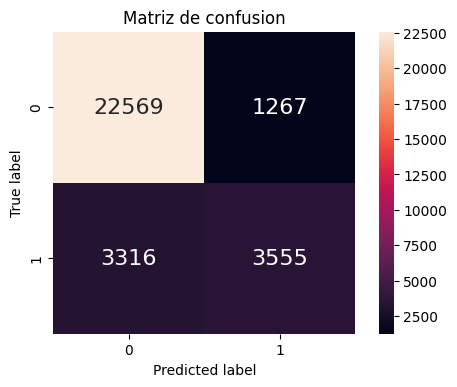

In [11]:
plot_confusion_matrix(resultados_val.to_numpy(), y_pred)

In [12]:
from sklearn.metrics import classification_report

print(classification_report(resultados_val, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91     23836
           1       0.74      0.52      0.61      6871

    accuracy                           0.85     30707
   macro avg       0.80      0.73      0.76     30707
weighted avg       0.84      0.85      0.84     30707



Vemos que el modelo presenta un accuracy y f1 score mejor que entrenando con otros modelos, por lo tanto ahora lo volveremos a entrenar buscando los mejores parametros.

# Buscando los mejores parametros

In [13]:
from sklearn.utils.fixes import loguniform

params = {'learning_rate': loguniform(1e-3, 0.99), 'max_depth': np.arange(3, 20)}

clf = GradientBoostingClassifier(random_state=117)

rgscv = RandomizedSearchCV(
    clf, params, n_iter=30, scoring='roc_auc', n_jobs=-1, cv=2, return_train_score=True, random_state=117
).fit(datos_training_boost, resultados_training_boost.values.ravel())
print(f"Best score: {rgscv.best_score_}")
print(f"Best params {rgscv.best_params_}")

Best score: 0.883306111991858
Best params {'learning_rate': 0.1578979378276272, 'max_depth': 8}


Con RandomSearch obtenemos que el mejor learning rate es 0.1578979378276272, y el mejor max_depth es 8.

In [13]:
clf_boosting = GradientBoostingClassifier(random_state=117, learning_rate=0.1578979378276272, max_depth= 8)
clf_boosting.fit(datos_training_boost, resultados_training_boost.values.ravel())

GradientBoostingClassifier(learning_rate=0.1578979378276272, max_depth=8,
                           random_state=117)

In [14]:
y_pred = clf_boosting.predict(datos_val)

Una vez obtenidas las predicciones nos interasa saber que tan bueno es el modelo, por lo tanto calcularemos distintas metricas tales como el accuracy, precion, recall y AUC ROC.

In [15]:
accuracy_score(y_pred, resultados_val)

0.8554075617937278

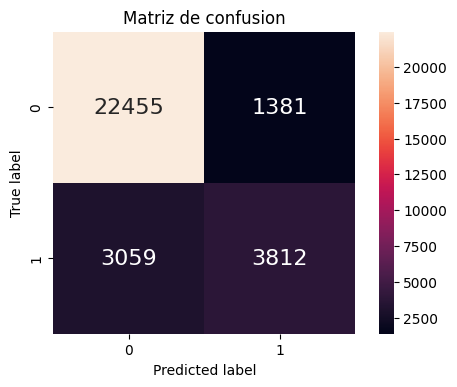

In [16]:
plot_confusion_matrix(resultados_val.to_numpy(), y_pred)

In [17]:
from sklearn.metrics import classification_report

print(classification_report(resultados_val, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     23836
           1       0.73      0.55      0.63      6871

    accuracy                           0.86     30707
   macro avg       0.81      0.75      0.77     30707
weighted avg       0.85      0.86      0.85     30707



In [18]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


def plot_roc(_fpr, _tpr, x):

    roc_auc = auc(_fpr, _tpr)

    plt.figure(figsize=(15, 10))
    plt.plot(
        _fpr, _tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})'
    )
    plt.scatter(_fpr, x)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

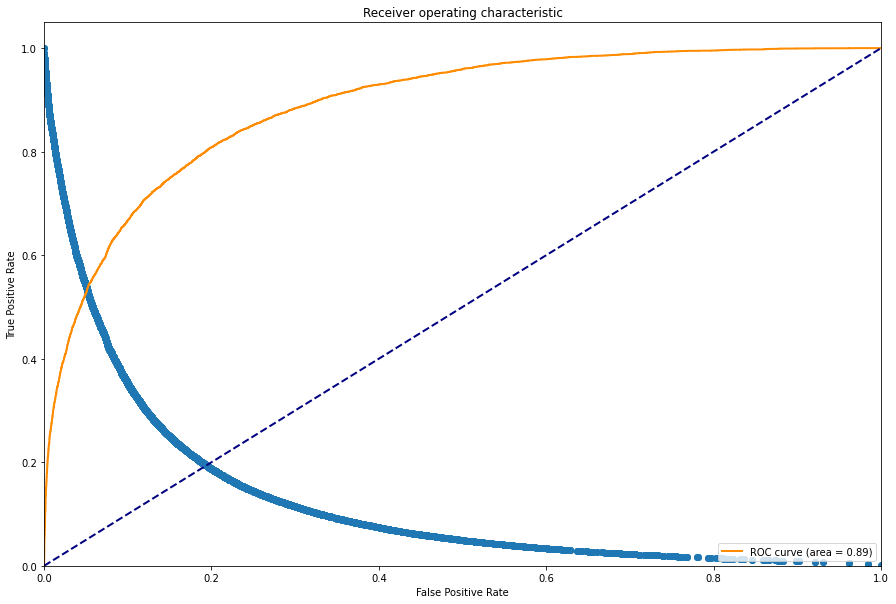

0.8885976930750953

In [19]:
fpr, tpr, thresholds = roc_curve(resultados_val.to_numpy(), clf_boosting.predict_proba(datos_val)[:, 1])

plot_roc(fpr, tpr, thresholds)
display(roc_auc_score(resultados_val.to_numpy(), clf_boosting.predict_proba(datos_val)[:, 1]))

Vemos que obtenemos un accuracy bastante alto y un AUC ROC mucho mayor a los otros modelos que entrenamos, por lo tanto usaremos Kfold para validar que no haya overfitting.

In [20]:
clf_boosting_kfold = GradientBoostingClassifier(
        random_state=117, learning_rate=0.1578979378276272, max_depth= 8)

def kfold(clf, X, y):
  kf = StratifiedKFold(n_splits=5)
  test_accuracies = []
  for fold_idx, (train_index, test_index) in enumerate(kf.split(X,y)):
    clf.fit(X[train_index], y[train_index])
    test_accuracy = accuracy_score(y[test_index], clf.predict(X[test_index]))
    print(f"fold {fold_idx}: accuracy score is {test_accuracy:.4f}")
    test_accuracies.append(test_accuracy)
  print(f"mean test accuracy is: {np.mean(test_accuracies):.4f}")

kfold(clf_boosting_kfold, datos_training_boost, resultados_training_boost.values.ravel())

fold 0: accuracy score is 0.8577
fold 1: accuracy score is 0.8564
fold 2: accuracy score is 0.8517
fold 3: accuracy score is 0.8545
fold 4: accuracy score is 0.8563
mean test accuracy is: 0.8553


# Reduciendo dimensionalidad

In [21]:
clf_boosting.feature_importances_

array([0.01477885, 0.05450138, 0.38779406, 0.02590946, 0.01423354,
       0.05834631, 0.01893698, 0.00762699, 0.072198  , 0.02597597,
       0.07479009, 0.02391909, 0.02888858, 0.02466114, 0.02702917,
       0.01840165, 0.01308596, 0.00213963, 0.01587552, 0.0136413 ,
       0.0127983 , 0.00358071, 0.0055063 , 0.00779227, 0.00342591,
       0.00415008, 0.00511196, 0.00300853, 0.00570128, 0.00367863,
       0.00944428, 0.01306808])

Dado que el modelo de boosting tiene el atributo feature_importances podemos utilizar SelectFromModel para seleccionar los features mas importantes.

In [22]:
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(estimator=clf_boosting, prefit=True)

In [23]:
selector.get_support()

array([False,  True,  True, False, False,  True, False, False,  True,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [24]:
datos_training_reduced = selector.transform(datos_training_boost)
pd.DataFrame(datos_training_reduced)

,0,1,2,3,4
0,7.644989,59.0,0.000000,1018.700012,28.0
1,5.800000,62.0,0.000000,1005.000000,72.0
2,7.200000,71.0,1.000000,1008.799988,35.0
3,7.644989,62.0,0.000000,1007.799988,39.0
4,7.644989,61.0,0.000000,1016.599976,30.0
...,...,...,...,...,...
71644,7.644989,33.0,0.000000,1018.099976,35.0
71645,7.644989,45.0,0.000000,1015.299988,33.0
71646,0.900000,66.0,11.800000,1020.599976,59.0
71647,7.644989,34.0,2.367993,1014.200012,96.0


Con este nuevo dataset entrenaremos el modelo y miraremos los resultados.

In [25]:
clf_boosting_reduced = GradientBoostingClassifier(random_state=117, learning_rate=0.1578979378276272, max_depth= 8)
clf_boosting_reduced.fit(datos_training_reduced, resultados_training_boost.values.ravel())

GradientBoostingClassifier(learning_rate=0.1578979378276272, max_depth=8,
                           random_state=117)

In [26]:
datos_val_reduced = selector.transform(datos_val)
y_pred_reduced = clf_boosting_reduced.predict(datos_val_reduced)

In [27]:
accuracy_score(y_pred_reduced, resultados_val)

0.840069039632657

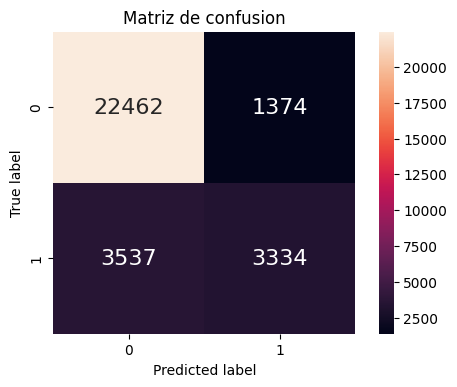

In [28]:
plot_confusion_matrix(resultados_val.to_numpy(), y_pred_reduced)

In [29]:
print(classification_report(resultados_val, y_pred_reduced))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90     23836
           1       0.71      0.49      0.58      6871

    accuracy                           0.84     30707
   macro avg       0.79      0.71      0.74     30707
weighted avg       0.83      0.84      0.83     30707



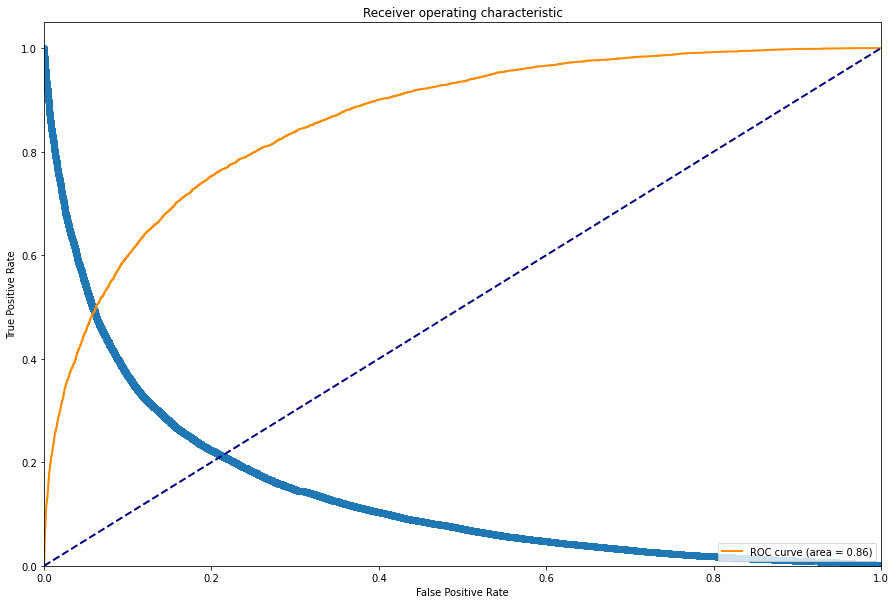

0.8605257316838498

In [30]:
fpr, tpr, thresholds = roc_curve(resultados_val.to_numpy(), clf_boosting_reduced.predict_proba(datos_val_reduced)[:, 1])

plot_roc(fpr, tpr, thresholds)
display(roc_auc_score(resultados_val.to_numpy(), clf_boosting_reduced.predict_proba(datos_val_reduced)[:, 1]))

Podemos ver que el AUC ROC disminuyo de 0.89 a 0.86, por lo tanto no usaremos este modelo.

## Modelo utilizando imputers

Uno vez que obtenemos los parametros y los features a utilizar, probaremos entrenar el modelo rellenando los missings del dataset con IterativeImputer (utilizando datos de las demas columnas) para ver si podemos conseguir mejores resultados.

In [31]:
from sklearn.impute import IterativeImputer

datos_training_iterative = preprocessing_(datos_training)
imputer = IterativeImputer(random_state=117, max_iter=50)
imputer.fit(datos_training_iterative)
datos_training_iterative = imputer.transform(datos_training_iterative)

pd.DataFrame(datos_training_iterative)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,12.0,5.855419,59.0,69.0,3.547174,0.000000,4.662774,5.157845,1018.700012,1021.3,...,6.0,-1.0,-5.0,8.0,0.0,-2.0,5.0,-1.0,2014.0,6.0
1,11.0,5.800000,62.0,67.0,6.400000,0.000000,3.000000,6.000000,1005.000000,1008.5,...,8.0,0.0,-5.0,8.0,0.0,-1.0,1.0,0.0,2013.0,11.0
2,19.0,7.200000,71.0,75.0,5.200000,1.000000,5.000000,5.000000,1008.799988,1011.2,...,3.0,-1.0,-4.0,6.0,0.0,-4.0,5.0,0.0,2012.0,11.0
3,5.0,8.739483,62.0,63.0,7.652876,0.000000,4.447522,4.419859,1007.799988,1009.0,...,4.0,0.0,-4.0,6.0,0.0,-3.0,4.0,0.0,2009.0,2.0
4,26.0,4.483617,61.0,84.0,0.556286,0.000000,5.239149,5.182721,1016.599976,1020.8,...,5.0,-1.0,-2.0,5.0,-1.0,-2.0,3.0,0.0,2016.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71644,14.0,10.808036,33.0,62.0,7.109894,0.000000,2.859081,1.986983,1018.099976,1022.1,...,6.0,-1.0,-1.0,3.0,-1.0,-4.0,5.0,0.0,2014.0,1.0
71645,21.0,9.795808,45.0,84.0,1.206283,0.000000,1.000000,2.000000,1015.299988,1020.1,...,4.0,-1.0,-3.0,4.0,0.0,-1.0,3.0,-1.0,2012.0,8.0
71646,5.0,0.900000,66.0,63.0,0.600000,11.800000,7.000000,8.000000,1020.599976,1019.7,...,4.0,0.0,-4.0,6.0,0.0,-3.0,4.0,0.0,2012.0,6.0
71647,30.0,9.233298,34.0,47.0,7.346034,2.476756,1.000000,2.242586,1014.200012,1017.1,...,8.0,0.0,-2.0,5.0,-1.0,-5.0,8.0,0.0,2014.0,7.0


In [36]:
params = {'learning_rate': loguniform(1e-3, 0.99), 'max_depth': np.arange(3, 20)}

clf = GradientBoostingClassifier(random_state=117)

rgscv = RandomizedSearchCV(
    clf, params, n_iter=30, scoring='roc_auc', n_jobs=-1, cv=2, return_train_score=True, random_state=117
).fit(datos_training_iterative, resultados_training_boost.values.ravel())
print(f"Best score: {rgscv.best_score_}")
print(f"Best params {rgscv.best_params_}")

Best score: 0.8814217678142866
Best params {'learning_rate': 0.04340652502562125, 'max_depth': 7}


In [32]:
clf_boosting_imputed = GradientBoostingClassifier(random_state=117, learning_rate=0.04340652502562125, max_depth= 7)
clf_boosting_imputed.fit(datos_training_iterative, resultados_training_boost.values.ravel())

GradientBoostingClassifier(learning_rate=0.04340652502562125, max_depth=7,
                           random_state=117)

Preprocesamos el dataset de validacon.

In [33]:
datos_val_iterative = preprocessing_(X_val_dev)
datos_val_iterative = imputer.transform(datos_val_iterative)

In [34]:
y_pred_imputed = clf_boosting_imputed.predict(datos_val_iterative)

In [35]:
accuracy_score(y_pred_imputed, resultados_val)

0.854593415182206

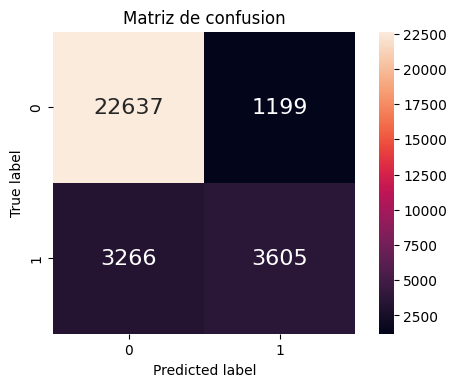

In [36]:
plot_confusion_matrix(resultados_val.to_numpy(), y_pred_imputed)

In [37]:
print(classification_report(resultados_val, y_pred_imputed))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91     23836
           1       0.75      0.52      0.62      6871

    accuracy                           0.85     30707
   macro avg       0.81      0.74      0.76     30707
weighted avg       0.85      0.85      0.84     30707



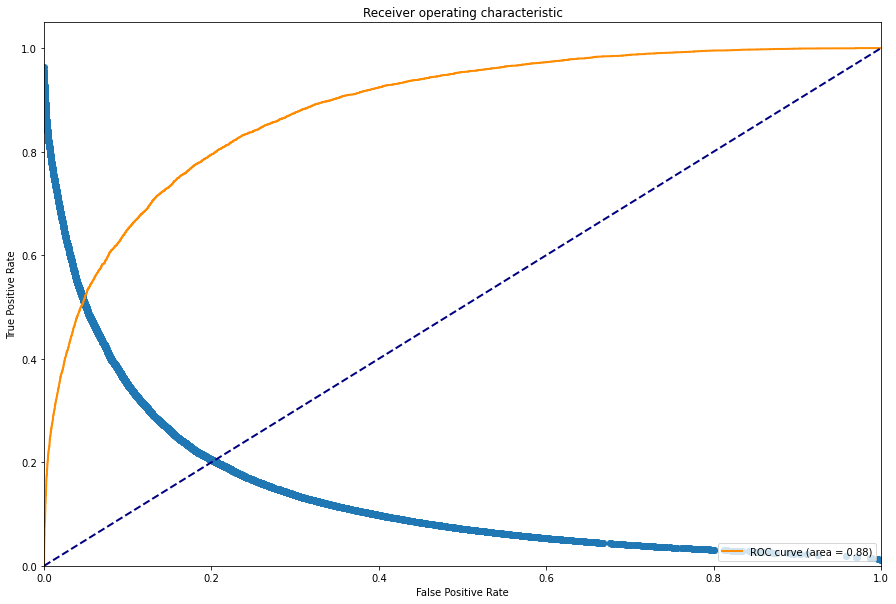

0.8826094342485712

In [38]:
fpr, tpr, thresholds = roc_curve(resultados_val.to_numpy(), clf_boosting_imputed.predict_proba(datos_val_iterative)[:, 1])

plot_roc(fpr, tpr, thresholds)
display(roc_auc_score(resultados_val.to_numpy(), clf_boosting_imputed.predict_proba(datos_val_iterative)[:, 1]))

Vemos que utilizar imputers no mejora la prediccion, y dado que es mas costoso de calcular no lo utilizaremos en nuestro modelo final.

# Predicciones sobre el test-holdout

In [5]:
_datos_training, datos_test = preprocessing_gb(X_training.copy(), X_test_holdout.copy())

resultados_test = y_test_holdout.copy()
resultados_test = resultados_test.reset_index()
resultados_test = resultados_test.drop(columns=['index'])
resultados_test = pd.get_dummies(resultados_test, drop_first=True, columns=['llovieron_hamburguesas_al_dia_siguiente'])

pd.DataFrame(datos_test)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,6.0,7.644989,69.0,66.0,5.45772,0.0,4.500233,4.437636,1023.000000,1026.1,...,1.0,0.0,-1.0,1.0,0.0,-1.0,1.0,0.0,2013.0,5.0
1,28.0,7.644989,31.0,64.0,5.45772,0.0,4.500233,4.437636,1017.400024,1020.0,...,8.0,0.0,-1.0,1.0,0.0,-2.0,3.0,0.0,2016.0,10.0
2,24.0,13.800000,49.0,56.0,5.40000,0.0,1.000000,7.000000,1012.200012,1013.8,...,7.0,0.0,-3.0,4.0,0.0,-3.0,4.0,0.0,2008.0,12.0
3,25.0,12.400000,31.0,64.0,8.60000,0.0,6.000000,1.000000,1011.700012,1016.5,...,1.0,0.0,-3.0,6.0,-1.0,-2.0,4.0,-1.0,2014.0,2.0
4,13.0,9.200000,47.0,74.0,4.00000,0.0,4.000000,5.000000,1022.200012,1023.4,...,8.0,0.0,-5.0,8.0,0.0,-5.0,8.0,0.0,2011.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11368,4.0,7.644989,32.0,74.0,5.45772,0.0,4.500233,4.437636,1022.799988,1025.2,...,4.0,0.0,-4.0,6.0,0.0,-3.0,4.0,0.0,2015.0,6.0
11369,30.0,7.644989,94.0,79.0,5.45772,0.0,4.500233,4.437636,1003.000000,1007.0,...,8.0,0.0,-3.0,6.0,-1.0,-5.0,8.0,0.0,2011.0,6.0
11370,2.0,0.000000,64.0,65.0,4.20000,0.0,7.000000,7.000000,1015.799988,1016.5,...,3.0,0.0,-1.0,1.0,0.0,-2.0,3.0,0.0,2014.0,9.0
11371,29.0,8.400000,58.0,91.0,2.20000,0.0,3.000000,4.000000,1024.000000,1026.0,...,6.0,0.0,-2.0,0.0,1.0,-4.0,6.0,0.0,2014.0,5.0


In [40]:
y_pred = clf_boosting.predict(datos_test)

In [41]:
accuracy_score(y_pred, resultados_test)

0.8576453002725754

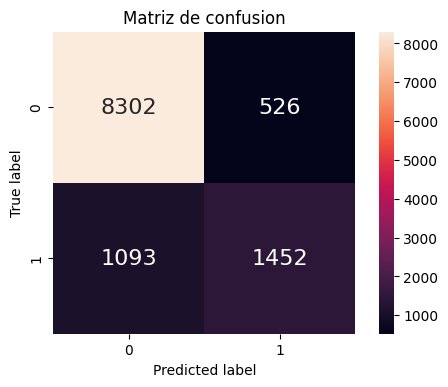

In [42]:
plot_confusion_matrix(resultados_test.to_numpy(), y_pred)

In [43]:
from sklearn.metrics import classification_report

print(classification_report(resultados_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      8828
           1       0.73      0.57      0.64      2545

    accuracy                           0.86     11373
   macro avg       0.81      0.76      0.78     11373
weighted avg       0.85      0.86      0.85     11373



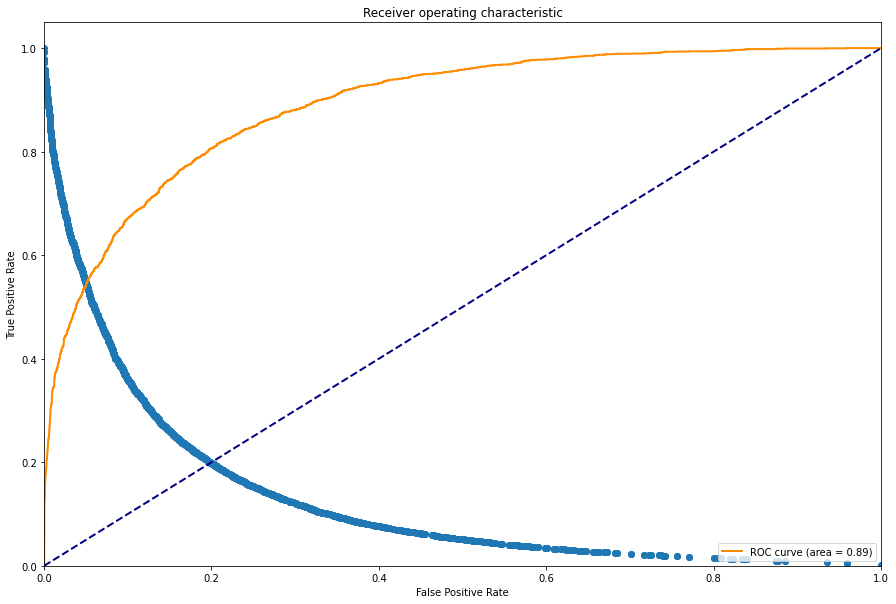

0.8898956971166043

In [44]:
fpr, tpr, thresholds = roc_curve(resultados_test.to_numpy(), clf_boosting.predict_proba(datos_test)[:, 1])

plot_roc(fpr, tpr, thresholds)
display(roc_auc_score(resultados_test.to_numpy(), clf_boosting.predict_proba(datos_test)[:, 1]))

# Prediccion final

In [45]:
datos_prediccion = pd.read_csv(
    'https://docs.google.com/spreadsheets/d/1mR_JNN0-ceiB5qV42Ff9hznz0HtWaoPF3B9zNGoNPY8/export?format=csv', low_memory=False
)
datos_prediccion

,barrio,dia,direccion_viento_tarde,direccion_viento_temprano,horas_de_sol,humedad_tarde,humedad_temprano,id,llovieron_hamburguesas_hoy,mm_evaporados_agua,...,presion_atmosferica_tarde,presion_atmosferica_temprano,rafaga_viento_max_direccion,rafaga_viento_max_velocidad,temp_max,temp_min,temperatura_tarde,temperatura_temprano,velocidad_viendo_tarde,velocidad_viendo_temprano
0,Villa General Mitre,2014-12-16,Oestesuroeste,Sursureste,13.4,38.0,51.0,116706,NaN,NaN,...,1010.9,1014.4,suroeste,41.0,26.8,8.9,24.9,20.6,28.0,13.0
1,Nueva Pompeya,2010-10-21,Nornoreste,Estesureste,NaN,39.0,57.0,58831,no,NaN,...,1020.2,1023.8,Norte,28.0,23.3,5.0,21.5,14.7,11.0,6.0
2,Constitución,2013-04-09,Estesureste,Oestenoroeste,3.6,73.0,90.0,31981,si,2.4,...,1024.3,1026.7,Oestenoroeste,24.0,22.0,15.6,20.7,16.7,6.0,15.0
3,Agronomía,2016-02-05,Sureste,Sureste,NaN,34.0,47.0,2533,no,NaN,...,1015.8,1018.3,Sureste,30.0,29.9,14.2,27.0,20.0,11.0,15.0
4,Balvanera,2012-06-05,suroeste,Noroeste,NaN,77.0,87.0,7270,no,2.0,...,1007.6,1006.0,suroeste,39.0,11.5,5.5,11.2,7.0,20.0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29087,Parque Chas,2013-04-24,suroeste,Oestenoroeste,NaN,71.0,77.0,73456,no,NaN,...,1018.9,1021.2,Oeste,37.0,19.8,9.8,17.3,12.8,9.0,13.0
29088,Belgrano,2015-10-30,Norte,Noreste,NaN,37.0,64.0,14471,no,NaN,...,1017.9,1021.8,Nornoreste,41.0,29.3,15.6,27.8,20.2,15.0,28.0
29089,Villa Crespo,2011-08-09,Nornoreste,Norte,10.1,31.0,77.0,106482,no,3.2,...,1011.1,1016.3,suroeste,41.0,19.8,5.5,18.6,11.1,20.0,11.0
29090,Caballito,2017-04-25,Nornoreste,Norte,NaN,81.0,90.0,21057,no,NaN,...,1008.2,1014.6,Nornoreste,39.0,25.4,17.8,22.0,19.5,33.0,15.0


In [46]:
_datos_training, X = preprocessing_gb(X_training.copy(), datos_prediccion.copy())
predicciones_gb = clf_boosting.predict(X)

predicciones_gb = pd.DataFrame(predicciones_gb).rename(columns= {0:'llovieron_hamburguesas_al_dia_siguiente'})
predicciones_gb.replace(0, 'no', inplace= True)
predicciones_gb.replace(1, 'si', inplace= True)
predicciones_gb

,llovieron_hamburguesas_al_dia_siguiente
0,no
1,no
2,si
3,no
4,no
...,...
29087,no
29088,no
29089,no
29090,no


In [47]:
predicciones_gb.to_csv("Gradient_Boosting.csv")